# BATs Language Metrics
This is an attempt to jupyterize Wally's Language Metrics script (lang_metrics.py)

Comment from the original script:
   PURPOSE: Calculate various metrics to describe code-switching behavior in language-tagged corpora.


In [7]:
# Lets import modules needed
import sys
import math
import numpy as np
import pandas as pd
from itertools import groupby
from collections import Counter
import csv

In [8]:
# These were the crux of the script. I would have preferred to rewrite these scripts 
# so they take some subset of the inputs: LANGS, LANG_TAGS and NUMTAGS
# but for now I am leaving them as they are. 
# Future plan: Make a class with these variables as class members and define a constructor
#              that does input file parsing and initializes these variables
def metrics():
        num_switchpoints()
        m_metric()
        i_metric()
        norm_i_metric()
        burstiness()
        fano_factor()
        memory()
        lang_entropy()
        span_entropy()
        switch_entropy()
        switch_surprisal()


def num_switchpoints():
        num_switches = 0

        for index, tag in enumerate(LANG_TAGS[1:]):
                if tag != LANG_TAGS[index - 1]:
                        num_switches += 1

        print("Number of switchpoints: {}".format(num_switches))
        return num_switches


def m_metric():
        num_langs = len(LANGS)
        counts = Counter(LANG_TAGS)
        m_metric = 0.0

        if num_langs == 1:
                print("M-metric: {}".format(m_metric))
                return

        # Compute p_i^2 for all languages in text
        p_lang = {}
        for lang, count in counts.items():
                p_lang[lang] = (count / float(NUMTAGS)) ** 2

        p_sum = sum(p_lang.values())
        m_metric = (1 - p_sum) / ((num_langs - 1) * p_sum)

        print("M-metric: {}".format(m_metric))
        return m_metric


def i_metric():
        # Count number of language switches for each language
        switches = {lang: {} for lang in LANGS}
        counts = Counter(zip(LANG_TAGS, LANG_TAGS[1:]))

        # Compute transition probabilities
        for (x, y), c in counts.items():
                switches[x][y] = c / float(NUMTAGS - 1)

        i_metric = 0.0

        # Sum all probabilities of switching language
        for lang1, switch in switches.items():
                for lang2, prob in switch.items():
                        if lang1 != lang2:
                                i_metric += prob

        print("I-metric: {}".format(i_metric))
        return i_metric
        
def norm_i_metric():
        i = i_metric()
        counts = Counter(LANG_TAGS)
        num_langs = len(LANGS)
        
        low = (num_langs - 1) / (NUMTAGS - 1)
        least = NUMTAGS - max(counts.values())
        high = min(2*least / (NUMTAGS - 1), 1)
        
        norm_i = (i - low)/(high - low)
        
        print("Normalized I-metric: {}".format(norm_i))
        return norm_i

def burstiness():
        spans = [len(list(group)) for lang, group in groupby(LANG_TAGS)]
        mean = np.mean(spans)
        sd = np.std(spans)
        burstiness = (sd - mean)/(sd + mean)

        print("Burstiness: {}".format(burstiness))
        return burstiness

def fano_factor():
        spans = [len(list(group)) for lang, group in groupby(LANG_TAGS)]
        mean = np.mean(spans)
        var = np.var(spans)
        fano = var / mean

        print("Fano: {}".format(fano))
        return fano

def memory():
        spans = [len(list(group)) for lang, group in groupby(LANG_TAGS)]
        mean1 = np.mean(spans[:-1])
        mean2 = np.mean(spans[1:])
        sd1 = np.std(spans[:-1])
        sd2 = np.std(spans[1:])
        memory = 0.0

        for i, span in enumerate(spans[:-1]):
                memory += (span - mean1) * (spans[i + 1] - mean2)

        memory /= (len(spans) - 1) * (sd1 * sd2)

        print("Memory: {}".format(memory))
        return memory


def spans():
        spans = [(lang, len(list(group))) for lang, group in groupby(LANG_TAGS)]

        print("Lang\tLength")

        for lang, length in spans:
                print("{}\t{}".format(lang, length))


def span_summary():
        spans = sorted([(lang, len(list(group))) for lang, group in groupby(LANG_TAGS)])
        spans = sorted([(c, len(list(cgen))) for c, cgen in groupby(spans)])

        print("Lang\tSpanLength\tSpanFreq")

        for (lang, length), freq in spans:
                print("{}\t{}\t{}".format(lang, length, freq))


def switchpoints():
        switchpoints = []

        # Compute vector of switch indices
        for index, tag in enumerate(LANG_TAGS[:-1]):
                if tag != LANG_TAGS[index + 1]:
                        switchpoints.append(index + 1)
                else:
                        switchpoints.append(0)

        for switch in switchpoints:
                print("{}".format(switch))


def lang_entropy():
        # Count frequencies of language tokens
        counts = Counter(LANG_TAGS)
        num_langs = len(LANGS)


        # Compute entropy based on unigram language tokens
        lang_entropy = 0.0
        for lang, count in counts.items():
                lang_prob = count / float(NUMTAGS)
                lang_entropy -= lang_prob * math.log2(lang_prob)
                
        lang_entropy /= math.log2(num_langs)

        print("Language Entropy: {}".format(lang_entropy))
        return lang_entropy


def span_entropy():
        # Get frequencies of language spans
        spans = [len(list(group)) for lang, group in groupby(LANG_TAGS)]
        span_counts = Counter(spans)
        total_count = len(spans)

        # Compute entropy based on spans of language tokens
        span_entropy = 0.0
        for length, count in span_counts.items():
                span_prob = count / float(total_count)
                span_entropy -= span_prob * math.log2(span_prob)
                
        span_entropy /= math.log2(len(span_counts))

        print("Span Entropy: {}".format(span_entropy))
        return span_entropy


def switch_entropy():
        switch_entropy = 0

        # Compute vector of switch indices
        for index, tag in enumerate(LANG_TAGS[:-1]):
                if tag != LANG_TAGS[index + 1]:
                        switch_entropy += 1
        
        switch_entropy = switch_entropy / (NUMTAGS - 1)
        switch_entropy = - switch_entropy * math.log2(switch_entropy)

        print("Switch Entropy: {}".format(switch_entropy))
        return switch_entropy


def switch_surprisal():
        surprisal = 0

        # Compute vector of switch indices
        for index, tag in enumerate(LANG_TAGS[:-1]):
                if tag != LANG_TAGS[index + 1]:
                        surprisal += 1

        surprisal = surprisal / (NUMTAGS - 1)
        surprisal = -math.log2(surprisal)

        print("Switch Surprisal: {}".format(surprisal))
        return surprisal

## Process
### Step1: Import file using pandas' `read_csv`
#### Delimiter
The input file is expected to be a comma(or tab) separated file specified by the delimiter.
#### Header
If the file has NO header then let read_csv know it, because by default it expects a header.

### Step2: Read all columns and give names to columns of interest
The file may have multiple columns but we only need the word and its language tag. If it has other columns just read them and ignore them. For example, the Solorio_7k dataset that has 3 columns and the KC dataset which has 7 columns. 
### Step3: Preprocessing data
#### Non-word tokens
Look for only tokens that have word characters;  Word characters include letters (lowercase,uppercase), digits, underscore and hyphen (`A-Za-z0-9_-`). It also includes unicode characters from other languages (needs testing to make sure).
#### Puntuation and Named Entities
For now, we will treat them the same way. Replace the language TAG ('Punct'/'Other', 'NamedEnt') with the language TAG preceeding it. 

In [9]:
langdata = pd.read_csv('../../codeswitch-annotation/Solorio7k/SolorioGoldStandard',header=None,sep='\t')
langdata.columns = ['word', 'language']
# Only get tokens that are words
langdata = langdata[langdata['word'].str.contains('(\w+)', regex=True)]
# Tokens tagged with language value as 'Other'/'Punct' and 'NamedEnt' are for 
# now converted to NaN. This lets use then do a fillna with a ffill method to 
# replace them with the previous language
langdata.replace(['Other', 'Punct', 'NamedEnt','O'], [None, None, None, None], inplace=True)
langdata.fillna(method='ffill', inplace=True)
# LANG_TAGS without puntuation and Named Entinty
LANG_TAGS = list(langdata['language'].values)
# Languages
LANGS = langdata['language'].unique()
# Number of words/tokens
NUMTAGS = len(LANG_TAGS)
# Lets get some stats
metrics()

Number of switchpoints: 514
M-metric: 0.6032507267542166
I-metric: 0.08076814459192319
I-metric: 0.08076814459192319
Normalized I-metric: 0.16020236087689715
Burstiness: 0.2809722569687539
Fano: 39.170111966506454
Memory: -0.12955480386964177
Language Entropy: 0.8132855669302232
Span Entropy: 0.8026734232749695
Switch Entropy: 0.29319400180773303
Switch Surprisal: 3.630069791612527


/Users/jacquelineserigos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


In [10]:
#Lets try it on a different dataset - KillerCronicas
langdata = pd.read_csv('../../codeswitch-annotation/KillerCronicas/Killer_Cronicas-output.txt',
                       delimiter=",",quoting=csv.QUOTE_NONE, encoding='utf-8')
langdata.columns = ['word','language']
# Only get tokens that are words
langdata = langdata[langdata['word'].str.contains('(\w+)', regex=True)]
# Tokens tagged with language value as 'Other'/'Punct' and 'NamedEnt' are for 
# now converted to NaN. This lets us then do a fillna with a ffill method to 
# replace them with the previous language
langdata.replace(['Other', 'Punct', 'NamedEnt','O'], [None, None, None, None], inplace=True)
langdata.fillna(method='ffill', inplace=True)
LANG_TAGS = list(langdata['language'].values)
# Languages
LANGS = langdata['language'].unique()
# Number of words/tokens
NUMTAGS = len(LANG_TAGS)
# Lets get some stats
metrics()

Number of switchpoints: 12757
M-metric: 0.9900635012562844
I-metric: 0.22435544430538173
I-metric: 0.22435544430538173
Normalized I-metric: 0.24138766935114608
Burstiness: 0.03661470638321851
Fano: 5.160128461582305
Memory: -0.013759199094242879
Language Entropy: 0.9963952680740545
Span Entropy: 0.6132748078068649
Switch Entropy: 0.4837421742722639
Switch Surprisal: 2.1561419013920498


/Users/jacquelineserigos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [7]:
#Lets try it on a different dataset - Solorio7k
langdata = pd.read_csv('../../codeswitch-annotation/Solorio7k/Solorio_7k-output.txt',
                       delimiter=",",quoting=csv.QUOTE_NONE, encoding='utf-8')
langdata.columns = ['word','language','yn']
# Only get tokens that are words
langdata = langdata[langdata['word'].str.contains('(\w+)', regex=True)]
# Tokens tagged with language value as 'Other'/'Punct' and 'NamedEnt' are for 
# now converted to NaN. This lets us then do a fillna with a ffill method to 
# replace them with the previous language
langdata.replace(['Other', 'Punct', 'NamedEnt','O'], [None, None, None, None], inplace=True)
langdata.fillna(method='ffill', inplace=True)
LANG_TAGS = list(langdata['language'].values)
# Languages
LANGS = langdata['language'].unique()
# Number of words/tokens
NUMTAGS = len(LANG_TAGS)
# Lets get some stats
metrics()

Number of switchpoints: 1308
M-metric: 0.36602988074363463
I-metric: 0.16013681592039805
I-metric: 0.16013681592039805
Normalized I-metric: 0.2675689744924519
Burstiness: 0.2031047250344083
Fano: 14.221953274090026
Memory: -0.17457413757262538
Language Entropy: 0.5825989239708359
Span Entropy: 0.6408204873222269
Switch Entropy: 0.4231812439648008
Switch Surprisal: 2.642623069108348


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [8]:
#Lets try it on a different dataset - KillerCronicas
langdata = pd.read_csv('KC_Output_Annotated_Complete.txt',
                       delimiter="\t",quoting=csv.QUOTE_NONE, encoding='utf-8')
langdata.columns = ['word','language','ne','e_ng_prob','sp_ng_prob','hmm_prob', 'tot_prob' ]
# Only get tokens that are words
langdata = langdata[langdata['word'].str.contains('(\w+)', regex=True)]
# Tokens tagged with language value as 'Other'/'Punct' and 'NamedEnt' are for 
# now converted to NaN. This lets us then do a fillna with a ffill method to 
# replace them with the previous language
langdata.replace(['Other', 'Punct', 'NamedEnt','O'], [None, None, None, None], inplace=True)
langdata.fillna(method='ffill', inplace=True)
LANG_TAGS = list(langdata['language'].values)
# Languages
LANGS = langdata['language'].unique()
# Number of words/tokens
NUMTAGS = len(LANG_TAGS)
# Lets get some stats
metrics()

Number of switchpoints: 13337
M-metric: 0.9885346558017482
I-metric: 0.23391929187697358
I-metric: 0.23391929187697358
Normalized I-metric: 0.2531144894389883
Burstiness: 0.015132220354787444
Fano: 4.54138126160089
Memory: -0.025836625300681752
Language Entropy: 0.9958369025453957
Span Entropy: 0.6170865451969784
Switch Entropy: 0.49027547797492654
Switch Surprisal: 2.0959172458198947


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [7]:
#Lets try it on a different dataset - YYB
langdata = pd.read_csv('YYB_Output_Annotated.txt',
                       delimiter="\t",quoting=csv.QUOTE_NONE, encoding='utf-8')
langdata.columns = ['word','language','ne','e_ng_prob','sp_ng_prob','hmm_prob', 'tot_prob' ]
# Only get tokens that are words
langdata = langdata[langdata['word'].str.contains('(\w+)', regex=True)]
# Tokens tagged with language value as 'Other'/'Punct' and 'NamedEnt' are for 
# now converted to NaN. This lets us then do a fillna with a ffill method to 
# replace them with the previous language
langdata.replace(['Other', 'Punct', 'NamedEnt','O'], [None, None, None, None], inplace=True)
langdata.fillna(method='ffill', inplace=True)
LANG_TAGS = list(langdata['language'].values)
# Languages
LANGS = langdata['language'].unique()
# Number of words/tokens
NUMTAGS = len(LANG_TAGS)
# Lets get some stats
metrics()

Number of switchpoints: 3202
M-metric: 0.9674659760199197
I-metric: 0.036769555467616406
Burstiness: 0.3749696867887837
Memory: -0.11611865333926795
Language Entropy: 0.9880387014531635
Span Entropy: 5.174198662369469
Switch Entropy: 0.17521959725520922
Switch Surprisal: 4.765344454858265


C:\Users\ry2333\anaconda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [13]:
#Lets try it on a different dataset - KillerCronicas Gold Standard
langdata = pd.read_csv('../../codeswitch-annotation/KillerCronicas/KillerCronicasGoldStandard',
                       delimiter="\t",quoting=csv.QUOTE_NONE, encoding='utf-8')
langdata.columns = ['word','language']
# The Gold Standard has way more language tags than the others:
# array(['Spn', 'Eng', Punct', 'NamedEnt', Num', 'EngNoSpace', 'NonStSpn', 'Ital',
#       'MixedNoSpace', 'Afrk', 'NonStEng', 'Mixed', 'Frn', 'SpnNoSpace',
#       'EngNonSt', 'Yidd', 'Latin']
#We still are only interested in languages tagged as Eng or Spn
# Tokens tagged with language values that seem like Eng/Spn and Punct, NamedEnt
# will be kept and now converted to NaN. 
# This lets us then do a fillna with a ffill method to 
# replace them with the previous language (hopefully Eng or Spn)
langdata.replace(['Punct', 'NamedEnt'
                ,'Num' , 'EngNoSpace', 'NonStSpn','MixedNoSpace', 'NonStEng', 'SpnNoSpace','EngNonSt'
                 ]
                  ,[None, None
                 , None , None, None, None, None, None, None
                   ], inplace=True)
langdata.fillna(method='ffill', inplace=True)
# Now drop other languages that are not Eng, Spn 
langdata = langdata[langdata['language'].str.contains('(^Spn$|^Eng$)', regex=True)]
LANG_TAGS = list(langdata['language'].values)
# Languages
LANGS = langdata['language'].unique()
# Number of words/tokens
NUMTAGS = len(LANG_TAGS)
# Lets get some stats
metrics()

Number of switchpoints: 2530
M-metric: 0.9879129203422643
I-metric: 0.14078777656513541
Burstiness: -0.0412341134902221
Memory: 0.04419927216271496
Language Entropy: 0.9956095450334453
Span Entropy: 4.129361776569194
Switch Entropy: 0.3982049937541405
Switch Surprisal: 2.828406012718803


C:\Users\ry2333\anaconda\lib\site-packages\ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


Number of switchpoints: 2530
M-metric: 0.9879129203422643
I-metric: 0.14078777656513541
Burstiness: -0.0412341134902221
Memory: 0.04419927216271496
Language Entropy: 0.9956095450334453
Span Entropy: 4.129361776569194
Switch Entropy: 0.3982049937541405
Switch Surprisal: 2.828406012718803


In [12]:
#Lets try it on a different dataset - BCBC
langdata = pd.read_csv('/Users/jacquelineserigos/Documents/GitHub/codeswitch-annotation/BonCop/BonCopTokensByLine_annotatedWithHMM_v4.tsv',
                       delimiter="\t",quoting=csv.QUOTE_NONE, comment='#', encoding='utf-8')
# Rename columns
langdata.columns = ['word', 'language']
# Tokens tagged with language value as 'Other'/'Punct' and 'NamedEnt' are for 
# now converted to NaN. This lets us then do a fillna with a ffill method to 
# replace them with the previous language
langdata.replace(['Other', 'Punct', 'NamedEnt','O'], [None, None, None, None], inplace=True)
langdata.fillna(method='ffill', inplace=True)
LANG_TAGS = list(langdata['language'].values)
# Languages
LANGS = langdata['language'].unique()
# Number of words/tokens
NUMTAGS = len(LANG_TAGS)
# Lets get some stats
metrics()







Number of switchpoints: 1058
M-metric: 0.9467069340327517
I-metric: 0.044737426857269835
I-metric: 0.044737426857269835
Normalized I-metric: 0.05351912665305761
Burstiness: 0.24470684945171087
Fano: 60.61021091457525
Memory: -0.12960969783108436
Language Entropy: 0.9801612808125195
Span Entropy: 0.8099598519045739
Switch Entropy: 0.20052987493849045
Switch Surprisal: 4.482373909841986


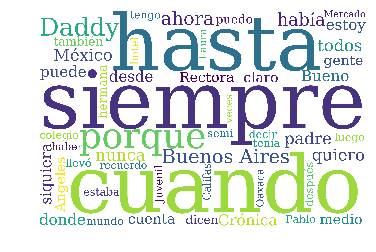

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
# Get all words 
#all_words = ' '.join(langdata['word'])
# Get only English words
eng_words = langdata[langdata['language'].str.contains(r'^Eng$')]['word']
# Get only Spanish words
spn_words = langdata[langdata['language'].str.contains(r'^Spn$')]['word']
# Get only words that are longer than N chars
N = 4
eng_string = ' '.join(x for x in eng_words if len(x)>N)
spn_string = ' '.join(x for x in spn_words if len(x)>N)
Ewordcloud = WordCloud(font_path='C:\\Users\\ry2333\\anaconda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf',max_words=50,background_color='white',
                          width=2400,
                          height=1600).generate(eng_string)
Swordcloud = WordCloud(font_path='C:\\Users\\ry2333\\anaconda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf',max_words=50,background_color='white',
                          width=2400,
                          height=1600).generate(spn_string)
plt.imshow(Swordcloud)
plt.axis('off')
plt.show()

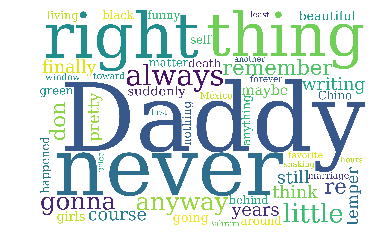

In [11]:
plt.imshow(Ewordcloud)
plt.axis('off')
plt.show()